In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Naive Bayes Classifier 

To create a naive bayes classifier from scratch, I needed to put in order the steps that needed to be taken:
* Import the data off of which we'll be building the classifier using pandas, and clean it if necessary.
* Calculating the prior for both values of $y$, the case that the person made more than 50K is classified as 'yes', and if they make less it's classified as 'no'. We then create a dictionary to contain both prior values.
* For each feature in the dataset, calculate the likelihood of that feature given $y = yes$ and $y = no$.
* Using the test data, we make predictions by calculating the probabilities of $y$ being yes and no respectively.
* We create a confusion matrix to find the sensitivity, specificity, as well as the posterior probability of $y$ being 'yes', or, the person making more than 50K.

# 1. Inspecting the Data

Creating a dataframe from the .data file was a bit of a problem at first, since I needed to manually add the column names as well as remove the commas. I also had to replace the question marks with actual np.NaN values to be detected as NA. 

In [2]:
df = pd.read_csv('adult.data', sep = ' ', header = None, names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'])

df.replace(',', '', regex=True, inplace=True)
df = df.replace('?', np.NaN)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  object
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  object
 3   education       32561 non-null  object
 4   education_num   32561 non-null  object
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  object
 11  capital-loss    32561 non-null  object
 12  hours-per-week  32561 non-null  object
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: object(15)
memory usage: 3.7+ MB


In [3]:
df.head()

,age,workclass,fnlwgt,education,education_num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
df

,age,workclass,fnlwgt,education,education_num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


The 'fnlwgt' feature is removed for redundancy, and for severely slowing down the processing since all of its values are unique, making it obsolete.

Also, to save myself the trouble, I removed the NA values. 

In [5]:
df = df.drop('fnlwgt', axis = 1)

In [6]:
df.dropna(inplace = True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30162 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30162 non-null  object
 1   workclass       30162 non-null  object
 2   education       30162 non-null  object
 3   education_num   30162 non-null  object
 4   marital-status  30162 non-null  object
 5   occupation      30162 non-null  object
 6   relationship    30162 non-null  object
 7   race            30162 non-null  object
 8   sex             30162 non-null  object
 9   capital-gain    30162 non-null  object
 10  capital-loss    30162 non-null  object
 11  hours-per-week  30162 non-null  object
 12  native-country  30162 non-null  object
 13  income          30162 non-null  object
dtypes: object(14)
memory usage: 3.5+ MB


We find the prior values by finding the total number of $y$ being yes and no, then dividing by the size of the dataset.

In [8]:
prior = {'yes': len(df[df['income'] == '>50K']) / df.shape[0], 'no': len(df[df['income'] == '<=50K']) / df.shape[0]}

prior

{'yes': 0.24892248524633645, 'no': 0.7510775147536636}

Since we're about to calculate the likelihood for each feature, we remove the target variable from the list of features to iterate through.

In [9]:
cols = df.columns.values.tolist()
cols.remove('income')

cols

['age',
 'workclass',
 'education',
 'education_num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country']

In [10]:
categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

continuous = ['age', 'education_num', 'capital-gain', 'capital-loss', 'hours-per-week']

df[continuous] = df[continuous].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30162 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30162 non-null  int32 
 1   workclass       30162 non-null  object
 2   education       30162 non-null  object
 3   education_num   30162 non-null  int32 
 4   marital-status  30162 non-null  object
 5   occupation      30162 non-null  object
 6   relationship    30162 non-null  object
 7   race            30162 non-null  object
 8   sex             30162 non-null  object
 9   capital-gain    30162 non-null  int32 
 10  capital-loss    30162 non-null  int32 
 11  hours-per-week  30162 non-null  int32 
 12  native-country  30162 non-null  object
 13  income          30162 non-null  object
dtypes: int32(5), object(9)
memory usage: 2.9+ MB


In [11]:
df

,age,workclass,education,education_num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


# 2. Creating the Classifier

Initially, we create a likelihood dataframe storing the value, and its yes/no likelihoods. Then, we iterate twice: once for all the features, once for each unique value in that feature. This is a bit computationally expensive, though.

When calculating the likelihood, we create a dictionary which we'll then insert into the dataframe we created, taking care that the keys match the dataframe column names.

In [12]:
likelihood_cat = pd.DataFrame(columns = ['Feature', 'Value', '>50K likelihood', '<=50K likelihood'])

likelihood_cat

,Feature,Value,>50K likelihood,<=50K likelihood


In [13]:
likelihood_con = pd.DataFrame(columns = ['Feature', 'Mean Yes', 'Var Yes', 'Mean No', 'Var No'])

likelihood_cat

,Feature,Value,>50K likelihood,<=50K likelihood


The likelihood is calculated as the probability of the feature occurring given the income range (number of both happening at the same time in the dataset), divided by the number of occurrences of the value of that range.

In [14]:
for feature in cols:
    if feature in categorical:
        for value in df[feature].unique().tolist():
            print('Discrete feature {}: {}'.format(feature, value))
            vals_disc = {'Feature': feature, 'Value': value,
                    '>50K likelihood': len(df[(df[feature] == value) & (df['income'] == '>50K')]) / len(
                        df[df['income'] == '>50K']),
                    '<=50K likelihood': len(df[(df[feature] == value) & (df['income'] == '<=50K')]) / len(
                        df[df['income'] == '<=50K'])}
            likelihood_cat.loc[len(likelihood_cat)] = vals_disc
        
    elif feature in continuous:
        print('Continuous feature: {}'.format(feature))
        yes_vals = df.query("income == '>50K'")[feature]
        no_vals = df.query("income == '<=50K'")[feature]
        yes_mean = np.mean(yes_vals)
        no_mean = np.mean(no_vals)
        yes_var = np.var(yes_vals)
        no_var = np.var(no_vals)

        vals = {'Feature': feature, 'Mean Yes': yes_mean, 'Var Yes': yes_var, 'Mean No': no_mean, 'Var No': no_var}
        print(vals)
        likelihood_con.loc[len(likelihood_con)] = vals

likelihood_cat

Continuous feature: age
{'Feature': 'age', 'Mean Yes': 43.95911028236548, 'Var Yes': 105.45131151527511, 'Mean No': 36.60806038668668, 'Var No': 181.28829205321483}
Discrete feature workclass: State-gov
Discrete feature workclass: Self-emp-not-inc
Discrete feature workclass: Private
Discrete feature workclass: Federal-gov
Discrete feature workclass: Local-gov
Discrete feature workclass: Self-emp-inc
Discrete feature workclass: Without-pay
Discrete feature education: Bachelors
Discrete feature education: HS-grad
Discrete feature education: 11th
Discrete feature education: Masters
Discrete feature education: 9th
Discrete feature education: Some-college
Discrete feature education: Assoc-acdm
Discrete feature education: 7th-8th
Discrete feature education: Doctorate
Discrete feature education: Assoc-voc
Discrete feature education: Prof-school
Discrete feature education: 5th-6th
Discrete feature education: 10th
Discrete feature education: Preschool
Discrete feature education: 12th
Discrete f

,Feature,Value,>50K likelihood,<=50K likelihood
0,workclass,State-gov,0.045818,0.041273
1,workclass,Self-emp-not-inc,0.095099,0.078794
2,workclass,Private,0.649441,0.768518
3,workclass,Federal-gov,0.048615,0.025514
4,workclass,Local-gov,0.081113,0.064359
...,...,...,...,...
93,native-country,Vietnam,0.000666,0.002604
94,native-country,Hong,0.000799,0.000574
95,native-country,Ireland,0.000666,0.000839
96,native-country,Hungary,0.000400,0.000441


In [15]:
likelihood_con

,Feature,Mean Yes,Var Yes,Mean No,Var No
0,age,43.959110,1.054513e+02,36.608060,181.288292
1,education_num,11.606420,5.608680e+00,9.629116,5.825189
2,capital-gain,3937.679808,2.069312e+08,148.893838,876791.795872
3,capital-loss,193.750666,3.513954e+05,53.448000,96263.386609
4,hours-per-week,45.706580,1.152675e+02,39.348592,142.814698


# 3. Testing the Classifier

Using the test file given, we create a second dataframe. 

In [16]:
test_df = pd.read_csv('adult.test', sep = ' ', header = None, names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'], na_values = '?')

test_df.replace(',', '', regex=True, inplace=True)
test_df = test_df.replace('?', np.NaN)

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16281 non-null  object
 1   workclass       15318 non-null  object
 2   fnlwgt          16281 non-null  object
 3   education       16281 non-null  object
 4   education_num   16281 non-null  object
 5   marital-status  16281 non-null  object
 6   occupation      15315 non-null  object
 7   relationship    16281 non-null  object
 8   race            16281 non-null  object
 9   sex             16281 non-null  object
 10  capital-gain    16281 non-null  object
 11  capital-loss    16281 non-null  object
 12  hours-per-week  16281 non-null  object
 13  native-country  16007 non-null  object
 14  income          16281 non-null  object
dtypes: object(15)
memory usage: 1.9+ MB


In [17]:
test_df.head()

,age,workclass,fnlwgt,education,education_num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K.


In [18]:
test_df = test_df.drop('fnlwgt', axis = 1)
test_df.dropna(inplace = True, ignore_index = True)

In [19]:
test_df[continuous] = test_df[continuous].astype(int)

In [20]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15060 entries, 0 to 15059
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             15060 non-null  int32 
 1   workclass       15060 non-null  object
 2   education       15060 non-null  object
 3   education_num   15060 non-null  int32 
 4   marital-status  15060 non-null  object
 5   occupation      15060 non-null  object
 6   relationship    15060 non-null  object
 7   race            15060 non-null  object
 8   sex             15060 non-null  object
 9   capital-gain    15060 non-null  int32 
 10  capital-loss    15060 non-null  int32 
 11  hours-per-week  15060 non-null  int32 
 12  native-country  15060 non-null  object
 13  income          15060 non-null  object
dtypes: int32(5), object(9)
memory usage: 1.3+ MB


In [21]:
test_df

,age,workclass,education,education_num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,34,Private,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15055,33,Private,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,<=50K.
15056,39,Private,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
15057,38,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
15058,44,Private,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


Now, as we try to make our predictions, we'll create a new column in the dataframe 'predicted_income'. We'll start by creating a simple list storing the predicted values, then casting them as a Series and then insert that series into the dataframe.

To predict the values, we'll do as follows:
* Calculate the probability of $y$ being yes/no by multiplying its respective prior to the product of the likelihood of each given feature.
* Keep in mind that this is the proportional probability, since we can ignore the probability of the features as it's common in both probabilities.

In [22]:
likelihood_con.query(f"Feature == 'age'").values.tolist()[0]

['age',
 43.95911028236548,
 105.45131151527511,
 36.60806038668668,
 181.28829205321483]

In [23]:
likelihood_cat.query(f"Value == 'Female' and Feature == 'sex'").values.tolist()

[['sex', 'Female', 0.148108684070325, 0.3827138695153174]]

In [24]:
preds = np.zeros(len(test_df))

for i in range(len(test_df)):
    prod_yes = prior['yes']
    prod_no = prior['no']

    for feature in cols:
        if feature in categorical:
            value = test_df.loc[i, feature]
            
            likelihoods = likelihood_cat.query(f"Value == '{value}' and Feature == '{feature}'").values.tolist()[0]
            yes_likelihood = float(likelihoods[2])
            no_likelihood = float(likelihoods[3])
      
            prod_yes = prod_yes * yes_likelihood
            prod_no = prod_no * no_likelihood
   
        elif feature in continuous:
            value = test_df.loc[i, feature]
            
            stats = likelihood_con.query(f"Feature == '{feature}'").values.tolist()[0]
            
            yes_likelihood = (1 / np.sqrt(2 * np.pi * stats[2])) * np.exp(-(value - stats[1]) ** 2 / (2 * stats[2]))
            no_likelihood = (1 / np.sqrt(2 * np.pi * stats[4])) * np.exp(-(value - stats[3]) ** 2 / (2 * stats[4]))
            
            prod_yes = prod_yes * yes_likelihood
            prod_no = prod_no * no_likelihood
            
            
    # Normalize
    prob_yes = prod_yes / (prod_yes + prod_no)
    prob_no = prod_no / (prod_yes + prod_no)
    
    preds[i] = 1 if (prob_yes > prob_no) else 0

In [25]:
predictions = pd.Series(preds)

test_df.insert(14, column="Prediction", value=predictions)

In [26]:
test_df.replace(0.0, '<=50K', regex = True, inplace = True)
test_df.replace(1.0, '>50K', regex = True, inplace = True)

In [27]:
test_df

,age,workclass,education,education_num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,Prediction
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,<=50K,<=50K,40,United-States,<=50K.,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,<=50K,<=50K,50,United-States,<=50K.,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,<=50K,<=50K,40,United-States,>50K.,<=50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,<=50K,40,United-States,>50K.,>50K
4,34,Private,10th,6,Never-married,Other-service,Not-in-family,White,Male,<=50K,<=50K,30,United-States,<=50K.,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15055,33,Private,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,<=50K,<=50K,40,United-States,<=50K.,<=50K
15056,39,Private,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,<=50K,<=50K,36,United-States,<=50K.,<=50K
15057,38,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,<=50K,<=50K,50,United-States,<=50K.,>50K
15058,44,Private,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,<=50K,40,United-States,<=50K.,>50K


In [28]:
confusion_mtrx = pd.crosstab(test_df['income'], test_df['Prediction'], rownames=['Actual'], colnames=['Prediction'])

confusion_mtrx

Prediction,<=50K,>50K
Actual,,
<=50K.,10549,811
>50K.,1832,1868


<Axes: xlabel='Prediction', ylabel='Actual'>

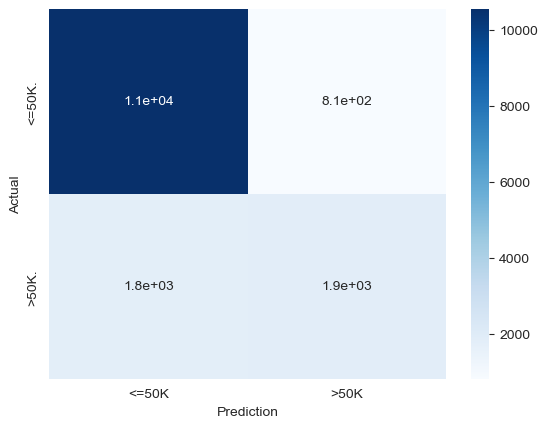

In [29]:
sns.heatmap(confusion_mtrx, cmap = 'Blues', annot = True)

In [30]:
TP = confusion_mtrx['>50K'].values.tolist()[1]
TN = confusion_mtrx['<=50K'].values.tolist()[0]
FP = confusion_mtrx['<=50K'].values.tolist()[1]
FN = confusion_mtrx['>50K'].values.tolist()[0]

print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FN)

posterior = TP / (TP + FP)

print(f"Sensitivity: {sensitivity}, Specificity: {specificity} \nPosterior Probability of Income being >50K: {posterior}")

TP: 1868, TN: 10549, FP: 1832, FN: 811
Sensitivity: 0.6972751026502426, Specificity: 0.9286091549295775 
Posterior Probability of Income being >50K: 0.5048648648648648


# A Different Approach

Having implemented the Naive Bayes model from scratch, I wanted to match it against the model offered by scikit-learn. Scikit-learn offers several kinds of Naive Bayes models, including: categorical, used for, intuitively, categorical features, and Gaussian, for continuous variables. Seeing as I had a higher ratio of discrete features, I decided to create a dataframe with only the categorical features and fit the model to them. 

In [31]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [32]:
df_model = df.drop(columns=['age', 'education_num', 'capital-gain', 'capital-loss', 'hours-per-week'])

df_model

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...
32556,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,United-States,<=50K
32557,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States,>50K
32558,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,United-States,<=50K
32559,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,United-States,<=50K


In [33]:
test_model = test_df.drop(columns=['age', 'education_num', 'capital-gain', 'capital-loss', 'hours-per-week'])

test_model

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income,Prediction
0,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,United-States,<=50K.,<=50K
1,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States,<=50K.,<=50K
2,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States,>50K.,<=50K
3,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,United-States,>50K.,>50K
4,Private,10th,Never-married,Other-service,Not-in-family,White,Male,United-States,<=50K.,<=50K
...,...,...,...,...,...,...,...,...,...,...
15055,Private,Bachelors,Never-married,Prof-specialty,Own-child,White,Male,United-States,<=50K.,<=50K
15056,Private,Bachelors,Divorced,Prof-specialty,Not-in-family,White,Female,United-States,<=50K.,<=50K
15057,Private,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K.,>50K
15058,Private,Bachelors,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,United-States,<=50K.,>50K


In [34]:
X = df_model.drop(columns = ['income'])
y = df_model['income']

In [35]:
X_test = test_model.drop(columns = ['income', 'Prediction'])
y_test = test_model['income']

In [36]:
encoder = LabelEncoder()
for col in X.columns:
    X[col] = encoder.fit_transform(X[col])

y = encoder.fit_transform(y)

for col in X_test.columns:
    X_test[col] = encoder.fit_transform(X_test[col])
    
y_test = encoder.fit_transform(y_test)

In [37]:
model = CategoricalNB()

model.fit(X, y)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy: ", accuracy)

print(report)

Accuracy:  0.8128154050464808
              precision    recall  f1-score   support

           0       0.87      0.88      0.88     11360
           1       0.62      0.61      0.62      3700

    accuracy                           0.81     15060
   macro avg       0.75      0.74      0.75     15060
weighted avg       0.81      0.81      0.81     15060


In [38]:
y_test_arr = np.array(y_test)
y_pred_arr = np.array(y_pred)

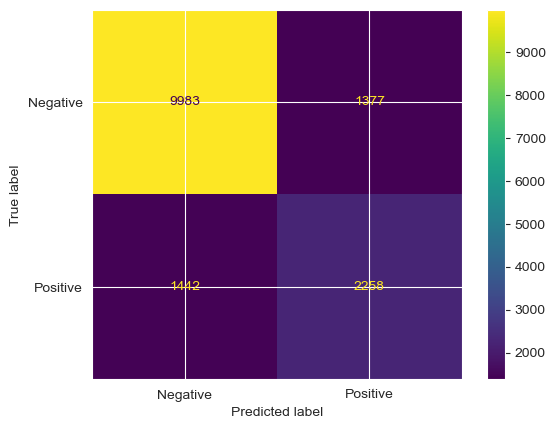

In [39]:
c_matrix = confusion_matrix(y_test_arr, y_pred_arr)
c_display = ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels = ['Negative', 'Positive'])

c_display.plot()